In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%matplotlib inline
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy import interpolate
from netCDF4 import Dataset
import wrf as wrfpy

In [3]:
# manually add a2e-mmc repos to PYTHONPATH if needed
import os, sys
#sys.path.append('../../../')
module_path = os.path.join(os.environ['HOME'],'a2e-mmc')
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from mmctools.plotting import plot_timehistory_at_height, plot_profile, plot_spectrum
from mmctools.helper_functions import calc_wind, model4D_calcQOIs
from mmctools.wrf.utils import wrfout_seriesReader #, model4D_calcQOIs 

In [5]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize']  = 16

# SWIFT Perturbation Methods Study 2013-11-08 CBL comparison: 
# Data analysis (template)

Simulation name and directory, and name of virtual towers

In [6]:
modeldatapath = '/glade/scratch/hawbecke/WRF/SWiFT_20131108_PertMethodsGroup/CBL_18Z-20z/'
modeldatafilter = 'wrfout_d02_2013-11-08_18:[0-5][0-9]:00'
#modeldatafilter = 'wrfout_d02_2013-11-08_18:00:00'
modelprocessedpath = '/glade/scratch/jsauer/A2E-MMC/PMIC1/ASSESSMENT/'
modelprocessedfile = 'WRF_d02-60minFull-wrfout-xarray.nc'
modelprocessedname = '{:s}{:s}'.format(modelprocessedpath,modelprocessedfile)

Name of output files

In [7]:
simname='PMIC-1'
output_tower0_10min   = os.path.join('./data',simname+'_tower0_10min.csv')
output_tower0_spectra = os.path.join('./data',simname+'_tower0_spectra.csv')
output_all_10min      = os.path.join('./data',simname+'_10min.csv')
output_all_spectra    = os.path.join('./data',simname+'_spectra.csv')

Heights and times at which spectra are computed. For each timestamp in `spectra_times`, the spectra will be computed for a period of `interval` starting at that timestamp with overlapping windows of size `window_size` (overlap of 50%). So with `interval = '1h'` and `window_size = '30min'`, each result will be the average of 3 overlapping windows.

In [8]:
spectra_heights = [10., 32., 80., 120.]
spectra_times = pd.date_range(start='2013-11-08 18:00:00',end='2013-11-08 20:00:00',freq='1h')
interval = '1h'
window_size = '30min'

Reference data 

In [9]:
#NetCDF file with WRF data at the SWiFT site generated in wrf_to_sowfa.ipynb, which can be found in
# a2e-mmc/assessment/studies/coupling_comparison/preprocessing/internal/
wrfdata = 'WRF_20131108-09.nc'

# Datasets generated in process_TTU_tower.ipynb, which can be found in
# a2e-mmc/assessment/datasets/SWiFT/
towerdata_10min = 'TTU_tilt_corrected_20131108-09_10min.csv'
towerdata       = 'TTU_tilt_corrected_20131108-09.csv'

# Dataset generated in process_TTU_radar.ipynb, which can be found in
# a2e-mmc/assessment/datasets/SWiFT/
radardata = 'TTU_obs_QC_20131108.csv'

#Setup a vector of heights at which wrf-data will be interpolated for all times
dz=4.0
nz=87
targetZ = np.linspace(0.5*dz,(nz-0.5)*dz,nz)


# Part 1: Load, process 4-D data

### 1a. Model-specific data loader

<font size=4><font color="red">**Define code-specific reader that returns a standardized xarrays DataSet:**</font></font>

- with dimensions `datetime`,`nz`,`ny`,`nx`
- with coordinate variables `*datetime`,`x`,`y`,`z`,`zsurface`,`lat`,`lon`
- standard column names `u`, `v`, `w`, `theta`,`p`,`wspd`,`wdir`
- standard SI units of [m], [m/s], and [K]

### 1b. If necessary construct Dataset from raw model outputs

In [11]:
if os.path.exists(modelprocessedname):
    print('{:s} exists, establishing reference to processed-dataset directly...'.format(modelprocessedname))
    %time ds=xr.open_mfdataset(modelprocessedname,chunks={'datetime': 10},combine='nested',concat_dim='datetime')
    #CPU times: user 19.7 ms, sys: 1.64 ms, total: 21.4 ms
    #Wall time: 21.4 ms     ### JAS note: this is fast because nothing is actually read or loaded into memory (lazy evaluation)
else:
    print('{:s} does not exist, reading 4-d model outputs and destaggering from wrfout(s)...'.format(modelprocessedname))
    %time ds = wrfout_seriesReader(modeldatapath,modeldatafilter)
    #CPU times: user 6min 6s, sys: 5min, total: 11min 6s
    #Wall time: 13min 4s   ###JAS this was for 60 time instances

/glade/scratch/jsauer/A2E-MMC/PMIC1/ASSESSMENT/WRF_d02-60minFull-wrfout-xarray.nc exists, establishing reference to processed-dataset directly...
CPU times: user 47.8 ms, sys: 22.1 ms, total: 69.9 ms
Wall time: 114 ms


## 2. Data processing

### 2a. Spanwise means and perturbations for all streamwise locations

In [12]:
if os.path.exists(modelprocessedname):
    print('{:s} exists, skipping calculation of quantities of interest...'.format(modelprocessedname))
else:
    %time ds=model4D_calcQOIs(ds,'ny')
    #CPU times: user 3min 3s, sys: 8min 20s, total: 11min 24s
    #Wall time: 17min 37s ###JAS this was for 60 time instances

###So here is the dataset...
ds

/glade/scratch/jsauer/A2E-MMC/PMIC1/ASSESSMENT/WRF_d02-60minFull-wrfout-xarray.nc exists, skipping calculation of quantities of interest...


<xarray.Dataset>
Dimensions:    (datetime: 60, nx: 960, ny: 480, nz: 87)
Coordinates:
    y          (ny, nx) float64 6.0 6.0 6.0 ... 5.754e+03 5.754e+03 5.754e+03
    x          (ny, nx) float64 6.0 18.0 30.0 ... 1.149e+04 1.15e+04 1.151e+04
    lat        (ny, nx) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    lon        (ny, nx) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    zsurface   (ny, nx) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
  * datetime   (datetime) datetime64[ns] 2013-11-08T18:00:00 ... 2013-11-08T18:59:00
    z          (datetime, nz, ny, nx) float32 dask.array<shape=(60, 87, 480, 960), chunksize=(10, 87, 480, 960)>
Dimensions without coordinates: nx, ny, nz
Data variables:
    u          (datetime, nz, ny, nx) float32 dask.array<shape=(60, 87, 480, 960), chunksize=(10, 87, 480, 960)>
    v          (datetime, nz, ny, nx) float32 dask.array<shape=(60, 87, 480, 960), chunksize=(10, 87, 480, 960)>
    w          (datetime, nz, ny, 

### 2b. Save full processed dataset, if desired

In [13]:
saveProcessedDataSetSwitch=True
if os.path.exists(modelprocessedname):
    print('{:s} exists, no need to save...'.format(modelprocessedname))
else:
    if saveProcessedDataSetSwitch:
        %time ds.to_netcdf(modelprocessedname, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
        #CPU times: user 1.34 s, sys: 1min 48s, total: 1min 50s
        #Wall time: 5min 23s

/glade/scratch/jsauer/A2E-MMC/PMIC1/ASSESSMENT/WRF_d02-60minFull-wrfout-xarray.nc exists, no need to save...


In [14]:
from matplotlib.colors import from_levels_and_colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from collections import namedtuple
Color = namedtuple("Color", "R G B")
from mpl_toolkits.basemap import Basemap, cm
cmVels = np.loadtxt('/glade/p/ral/nsap/jsauer/JAS/FastEddy/velsmap_v3.txt')
cmVels.shape
cmVels[0:4,0:4]
_FEvels_colors_1 = cmVels[:,0:3].tolist()
FEvels_colors_1 = ListedColormap(_FEvels_colors_1, name='FEvels_colors_1')
plt.register_cmap(name='FEvels_colors_1', cmap=FEvels_colors_1)
plt.set_cmap(FEvels_colors_1)

<Figure size 432x288 with 0 Axes>

In [43]:
levels=[5,10,15,30,40]
#iLocs=[25,30,40,50,60,100,200,300,500,700,900] #original
#iLocs=[25,30,40,60,120,220,320,420,560,700,900] #v2
iLocs=[25,40,120,240,300,360,420,480,540,700,850]
print(len(iLocs))

11


In [44]:
%%time
#Spatial spectra
from scipy.signal import welch
from scipy.signal.windows import hann, hamming
vertLevel=15
print('averaging over {:d} Times'.format(ds.dims['datetime']))
nblock = ds.dims['ny']
overlap = 0
win = hamming(nblock, True)
Puuf_cum = np.zeros((len(iLocs),np.floor(ds.dims['ny']/2).astype(int)+1))


cnt=0.0
for it in range(ds.dims['datetime']):
    dt = ds.attrs['DX']
    fs = 1 / dt
    cnt_i=0
    for iLoc in iLocs:
        y = ds['UU'].isel(datetime=it,nz=vertLevel,nx=iLoc)  #Could maybe use .sel(datetime=value,nz=vertLevel,nx=iLoc) if we pass in value 

        datos = y
        
        f, Pxxf = welch(datos, fs, window=win, noverlap=overlap, nfft=nblock, return_onesided=True, detrend='constant')
        if it is 0:
            Puuf_cum[cnt_i,:] = Pxxf
        else:
            Puuf_cum[cnt_i,:] = Puuf_cum[cnt_i,:] + Pxxf
        cnt_i = cnt_i+1
    cnt=cnt+1.0
Puuf=(1.0/cnt)*Puuf_cum

##Past-timing
#CPU times: user 2 s, sys: 1.32 s, total: 3.31 s
#Wall time: 17.9 s
##New-timing: From 60-time instance reload of the full procesed datafile
#CPU times: user 1.49 s, sys: 184 ms, total: 1.67 s
#Wall time: 4.42 s

averaging over 60 Times
CPU times: user 1.58 s, sys: 187 ms, total: 1.76 s
Wall time: 4.19 s


In [45]:
%%time
from scipy.stats import skew,kurtosis
bins_vector = np.linspace(-5.0,5.0,240)
hist_cum = np.zeros((len(iLocs),bins_vector.size-1))
fld='w' #'theta'
fldMean='wMean' #'thetaMean'
kLoc=levels[2]
cnt=0.0
for it in range(ds.dims['datetime']):
    cnt_i=0
    for iLoc in iLocs:
        y = (ds[fld].isel(datetime=it,nz=kLoc,nx=iLoc)-ds[fldMean].isel(datetime=it,nz=kLoc,nx=iLoc))

        datos = y
        hist,bin_edges=np.histogram(y, bins=bins_vector)
        if it is 0:
            hist_cum[cnt_i,:] = hist
        else:
            hist_cum[cnt_i,:] = hist_cum[cnt_i,:] + hist
        cnt_i = cnt_i+1
    cnt=cnt+1.0
dist= (ds[fld]-ds[fldMean])

sk_vec=np.zeros(len(iLocs))
kurt_vec=np.zeros(len(iLocs))
max_histval = np.amax(hist_cum/(ds.dims['datetime']*ds.dims['ny']),axis=(0,1))
cnt_i=0
for iLoc in iLocs:
    sk = skew(np.ndarray.flatten(dist.isel(nz=kLoc,nx=iLoc).values))
    kurt = kurtosis(np.ndarray.flatten(dist.isel(nz=kLoc,nx=iLoc).values))
    sk_vec[cnt_i]=sk
    kurt_vec[cnt_i]=kurt
    cnt_i += 1
##Past-timing
#CPU times: user 1min 42s, sys: 2min 16s, total: 3min 59s
#Wall time: 8min 3s
##New-timing: From 60-time instance reload of the full procesed datafile
#CPU times: user 37.6 s, sys: 1min 54s, total: 2min 31s
#Wall time: 2min 44s

CPU times: user 40.2 s, sys: 1min 56s, total: 2min 36s
Wall time: 2min 50s


ax[0] setup complete...
ax[1] setup complete...
ax[2] setup complete...
ax[3] setup complete...
ax[4] setup complete...
ax[5] setup complete...
ax[6] setup complete...
ax[7] setup complete...
ax[8] setup complete...
ax[9] setup complete...
ax[10] setup complete...
0 30
ax[11] setup complete...
ax[12] setup complete...
ax[13] setup complete...
ax[14] setup complete...
ax[15] setup complete...
ax[16] setup complete...
CPU times: user 3.68 s, sys: 541 ms, total: 4.23 s
Wall time: 6.55 s


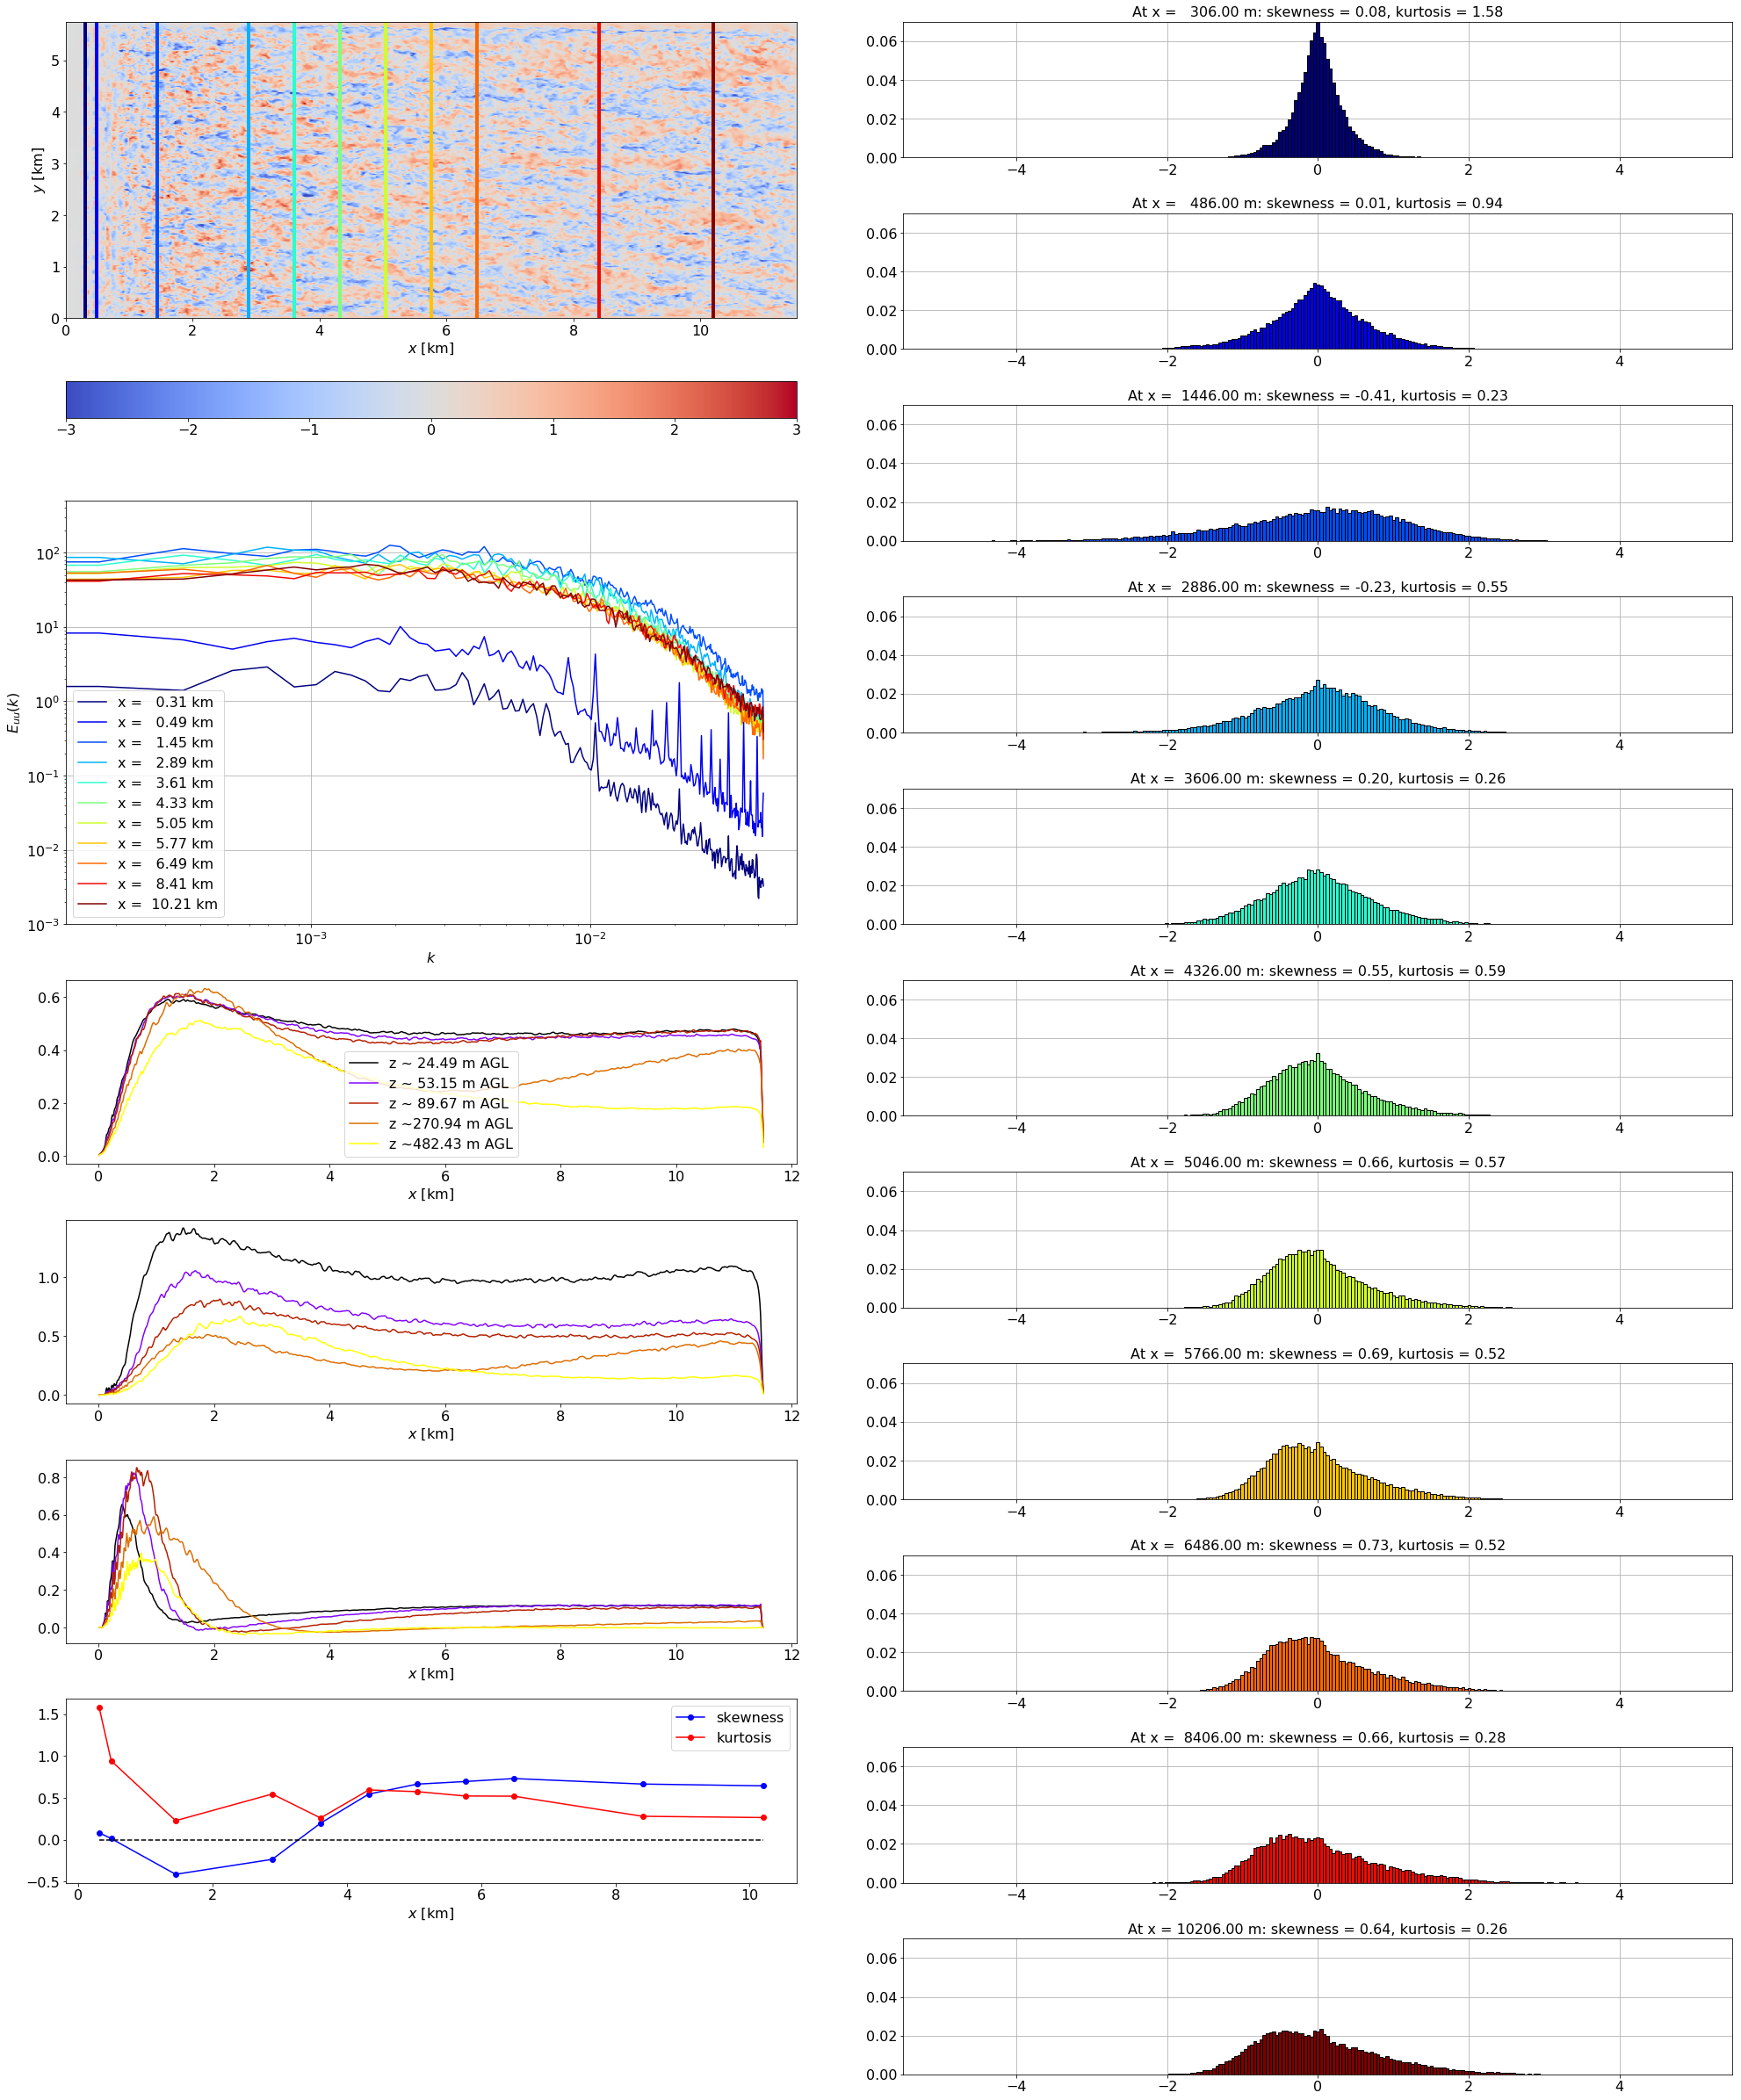

In [46]:
%%time
from matplotlib.gridspec import GridSpec

fntSize=16
###Try using grispec to layout multiple plots in a single plot frame....
fig = plt.figure(figsize=(34,len(iLocs)*4))
gs=GridSpec(len(iLocs)*4,34)

ax=[]
cnt_i=0
for iLoc in iLocs:
    ax.append(fig.add_subplot(gs[cnt_i*4:(cnt_i+1)*4-1,17:34]))   #The histograms
    print('ax[{:d}] setup complete...'.format(cnt_i))
    cnt_i=cnt_i+1
numLeftColumnPlots = 6
axhgt = np.floor(len(iLocs)*4/(numLeftColumnPlots+2)).astype(int)
print(0*axhgt,numLeftColumnPlots*axhgt)
ax.append(fig.add_subplot(gs[0*axhgt:2*axhgt-1,0:15]))  # The pcolormesh with overlayed lines of fetch
axpc=cnt_i
print('ax[{:d}] setup complete...'.format(axpc))
cnt_i=cnt_i+1
ax.append(fig.add_subplot(gs[2*axhgt:4*axhgt-1,0:15]))  # The spectra plot
axsp=cnt_i
print('ax[{:d}] setup complete...'.format(axsp))
cnt_i=cnt_i+1
ax.append(fig.add_subplot(gs[4*axhgt:5*axhgt-1,0:15]))  # The TKE vs. fetch plot
axTKE=cnt_i
print('ax[{:d}] setup complete...'.format(axTKE))
cnt_i=cnt_i+1
ax.append(fig.add_subplot(gs[5*axhgt:6*axhgt-1,0:15]))  # The <U'w'> vs. fetch plot
axUw=cnt_i
print('ax[{:d}] setup complete...'.format(axUw))
cnt_i=cnt_i+1
ax.append(fig.add_subplot(gs[6*axhgt:7*axhgt-1,0:15]))  # The <w'th'> vs. fetch plot
axwth=cnt_i
print('ax[{:d}] setup complete...'.format(axwth))
cnt_i=cnt_i+1
ax.append(fig.add_subplot(gs[7*axhgt:8*axhgt-1,0:15]))  # The stats plot
axst=cnt_i
print('ax[{:d}] setup complete...'.format(axst))
cnt_i=cnt_i+1

########----  Multiple time instance histogram for each fetch-wise location in iLocs
n = len(iLocs)
colors = plt.cm.jet(np.linspace(0,1,n))
cnt_i=0
for iLoc in iLocs:
    ax[cnt_i].grid(zorder=0)
    #im=ax[cnt_i].bar(bins_vector[:-1], hist_cum[cnt_i,:]/(ds.dims['Time']*ds.dims['south_north']), width=np.diff(bin_edges),color=colors[cnt_i], ec="k", align="edge",zorder=3)
    im=ax[cnt_i].bar(bins_vector[:-1], hist_cum[cnt_i,:]/(ds.dims['datetime']*ds.dims['ny']), width=np.diff(bin_edges),color=colors[cnt_i], ec="k", align="edge",zorder=3)
    ax[cnt_i].set_title('At x = {:8.2f} m: skewness = {:4.2f}, kurtosis = {:4.2f}'.format(ds['x'].isel(ny=0,nx=iLoc).values,sk_vec[cnt_i],kurt_vec[cnt_i]),fontsize=fntSize)
    ax[cnt_i].set_ylim(0.0,max_histval)
    ax[cnt_i].set_ylim(0.0,max_histval)
    cnt_i=cnt_i+1

########----  The pcolormesh and overlayed fetch lines plot
im = ax[axpc].pcolormesh(ds.x/1e3,ds.y/1e3,
                    ds['wspd'].isel(datetime=5,nz=vertLevel)-ds['UMean'].isel(datetime=5,nz=vertLevel),
                    zorder=1,cmap=plt.cm.coolwarm,vmin=-3, vmax=3)
                    #zorder=1,cmap=plt.cm.nipy_spectral)
                    #zorder=1,cmap=plt.cm.cubehelix)
                    #zorder=1,cmap=FEvels_colors_1)
ax[axpc].set_ylabel(r'$y$ $[\mathrm{km}]$',fontsize=fntSize)
ax[axpc].set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
fig.colorbar(im, ax=ax[axpc], orientation='horizontal',pad=0.15)

colors = plt.cm.jet(np.linspace(0,1,n))
cnt_i=0
for iLoc in iLocs: 
    im=ax[axpc].plot(ds.x.isel(nx=iLoc)/1e3,ds.y.isel(nx=iLoc)/1e3,'-',linewidth=4,color=colors[cnt_i],label='iLoc')
    cnt_i=cnt_i+1

########----  The spectra versus fetch plot
n = len(iLocs)
colors = plt.cm.jet(np.linspace(0,1,n))

cnt_i=0
for iLoc in iLocs:
    ax[axsp].loglog(f, Puuf[cnt_i,:].transpose(),'-',color=colors[cnt_i],label='x = {:6.2f} km'.format(ds['x'].isel(ny=0,nx=iLoc).values/1e3))
    cnt_i = cnt_i + 1
ax[axsp].grid()
#print('k-lowest = {:f}'.format(f[0]*(ds.dims['south_north']*ds.attrs['DX'])))
#print('k-highest = {:f}'.format(f[-1]*(ds.dims['south_north']*ds.attrs['DX'])))
#print('series length = {:d}'.format(nblock))
ax[axsp].set_ylim([1e-3,5e2])
ax[axsp].set_ylabel(r'$E_{uu}(k)$',fontsize=fntSize)
ax[axsp].set_xlabel(r'$k$',fontsize=fntSize)
ax[axsp].legend(loc='lower left',prop=dict(size=fntSize))

########----  The TKE, <U'w'>, and <w'th'> fetch plot
n = len(levels)
#colors = plt.cm.coolwarm(np.linspace(0,1,n))
#colors = plt.cm.gnuplot2(np.linspace(0,1,n))
colors = plt.cm.gnuplot(np.linspace(0,1,n))
cnt_k=0
#for lev in levels[-1:0:-1]:
for lev in levels:
    ax[axTKE].plot(ds.x.isel(ny=0)/1e3,ds['TKE'].sel(nz=lev).mean('ny').mean('datetime').transpose(),
                   color=colors[cnt_k],
                   label='z ~{:6.2f} m AGL'.format(ds['z'].isel(datetime=0,nz=lev,ny=0,nx=0).values))
    ax[axTKE].set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
    ax[axUw].plot(ds.x.isel(ny=0)/1e3,ds['Uw'].sel(nz=lev).mean('ny').mean('datetime').transpose(),color=colors[cnt_k])
    ax[axUw].set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
    ax[axwth].plot(ds.x.isel(ny=0)/1e3,ds['wth'].sel(nz=lev).mean('ny').mean('datetime').transpose(),color=colors[cnt_k])
    ax[axwth].set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
    cnt_k = cnt_k+1
ax[axTKE].legend(loc='lower center',fontsize=fntSize)

########----  The stats versus fetch plot
ax[axst].plot(ds.x.isel(ny=0,nx=iLocs)/1e3,sk_vec,'o-',color='b',label='skewness')
ax[axst].plot(ds.x.isel(ny=0,nx=iLocs)/1e3,kurt_vec,'o-',color='r',label='kurtosis')
ax[axst].set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
ax[axst].legend(loc='upper right',fontsize=fntSize)
ax[axst].plot(ds.x.isel(ny=0,nx=iLocs)/1e3,np.zeros(ds.x.isel(ny=0,nx=iLocs).values.shape),'--',color='k',label='skewness = 0 (symmetric), kurtosis = 0 (normal)')

##Past-timing
#CPU times: user 3.9 s, sys: 7.3 s, total: 11.2 s
#Wall time: 2min 4s  

In [47]:
saveFileName = "{:s}{:s}/Microscale_AssessmentMontage60minutes_iLocs-v3.png".format('/glade/scratch/jsauer/A2E-MMC/','')
print(saveFileName)
fig.savefig(saveFileName,dpi=200)

/glade/scratch/jsauer/A2E-MMC//Microscale_AssessmentMontage60minutes_iLocs-v3.png
